# Data Preparation PipeLine
**Daniel Triviño**

## Libary Imports

In [70]:
import pandas as pd
import datetime
from matplotlib import pyplot as plt
from pandas.tseries.holiday import AbstractHolidayCalendar, Holiday, nearest_workday, MO, FR
from pandas.tseries.offsets import DateOffset, WeekOfMonth

# Data Loading and visualization

In [71]:
df = pd.read_excel('../data/original/encoded_db.xlsx')
print(df.columns)
df


Index(['Unnamed: 0', 'index', 'date', 'Encoded Products', 'Cadereyta total $',
       'Cadereyta ctdad', 'Coahuila total $', 'Coahuila ctdad',
       'Durango total $', 'Durango ctdad', 'Expos F total $', 'Expos F ctdad',
       'Laredo total $', 'Laredo ctdad', 'Monterrey total $',
       'Monterrey ctdad', 'Online total $', 'Online ctdad',
       'Queretaro total $', 'Queretaro ctdad', 'Reynosa total $',
       'Reynosa ctdad', 'San Luis total $', 'San Luis ctdad',
       'Total libre de impuestos', 'Ctdad Ordenada', 'Indefinido total $',
       'Indefinido ctdad'],
      dtype='object')


,Unnamed: 0,index,date,Encoded Products,Cadereyta total $,Cadereyta ctdad,Coahuila total $,Coahuila ctdad,Durango total $,Durango ctdad,...,Queretaro total $,Queretaro ctdad,Reynosa total $,Reynosa ctdad,San Luis total $,San Luis ctdad,Total libre de impuestos,Ctdad Ordenada,Indefinido total $,Indefinido ctdad
0,0,4,02 ene 2022,Producto 11,0.00,0.0,0.000,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,18162.13,3.5,58623.600,10.5,NaN,NaN
1,1,5,02 ene 2022,Producto 6,0.00,0.0,0.000,0.0,0.0,0.0,...,23477.44,3.5,0.0,0.0,0.00,0.0,23477.440,3.5,NaN,NaN
2,2,6,02 ene 2022,Producto 24,0.00,0.0,0.000,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.00,0.0,31083.500,3.5,NaN,NaN
3,3,7,02 ene 2022,Producto 15,0.00,0.0,0.000,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.00,0.0,42846.020,7.0,NaN,NaN
4,4,8,02 ene 2022,Producto 9,0.00,0.0,27154.855,3.5,0.0,0.0,...,0.00,0.0,0.0,0.0,0.00,0.0,27154.855,3.5,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26459,26459,4317,31 dic 2023,Producto 273,0.00,0.0,34740.090,3.5,0.0,0.0,...,0.00,0.0,0.0,0.0,0.00,0.0,60970.805,7.0,NaN,NaN
26460,26460,4318,31 dic 2023,Producto 273,35273.21,3.5,0.000,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.00,0.0,35273.210,3.5,NaN,NaN
26461,26461,4319,31 dic 2023,Producto 273,0.00,0.0,0.000,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.00,0.0,41274.205,3.5,NaN,NaN
26462,26462,4320,31 dic 2023,Producto 273,0.00,0.0,0.000,0.0,0.0,0.0,...,15192.10,3.5,0.0,0.0,0.00,0.0,15192.100,3.5,NaN,NaN


# Data Cleaning

**Useless column removal**

In [72]:
df.drop(['index', 'Unnamed: 0', 'Indefinido total $', 'Indefinido ctdad', 'Ctdad Ordenada', 'Total libre de impuestos'], axis=1, inplace=True)

**Date formatting**

In [73]:
month_dict = {
    "ene": "01",
    "feb": "02",
    "mar": "03",
    "abr": "04",
    "may": "05",
    "jun": "06",
    "jul": "07",
    "ago": "08",
    "sep": "09",
    "oct": "10",
    "nov": "11",
    "dic": "12"
}

def date_formatter(date:str):
    date = date.strip().split()
    year = date[2]
    month = month_dict[date[1].lower()]
    day = date[0]
    return f"{year}-{month}-{day}"

df["date"] = df["date"].apply(date_formatter)

**Convert columns into rows**

In [74]:
localizaciones = ['Cadereyta', 'Coahuila', 'Durango', 'Expos F', 'Laredo', 'Monterrey', 'Online', 'Queretaro', 'Reynosa', 'San Luis']

# Crear un nuevo dataframe vacío
new_df = pd.DataFrame(columns=['Date', 'Location', 'Product', 'Amount', 'Total'])
new_dict = {"Date": [], "Location": [], "Product": [], "Amount": [], "Total": []}
# Iterar sobre cada fila del dataframe original
for idx, row in df.iterrows():
    for localizacion in localizaciones:
        # Si el total para la localización actual no es 0, agregar una nueva fila al nuevo dataframe
        if row[f'{localizacion} total $'] != 0:
            new_row = {
                'Date': [row['date']],
                'Location': [localizacion],
                'Product': [row['Encoded Products']],
                'Amount': [row[f'{localizacion} ctdad']],
                'Total': [row[f'{localizacion} total $']]
            }
            new_dict["Date"].append(row['date'])
            new_dict["Location"].append(localizacion)
            new_dict["Product"].append(row['Encoded Products'])
            new_dict["Amount"].append(row[f'{localizacion} ctdad'])
            new_dict["Total"].append(row[f'{localizacion} total $'])
            # print(new_row)
new_df = pd.DataFrame(new_dict)


new_df



,Date,Location,Product,Amount,Total
0,2022-01-02,Monterrey,Producto 11,7.0,40461.470
1,2022-01-02,San Luis,Producto 11,3.5,18162.130
2,2022-01-02,Queretaro,Producto 6,3.5,23477.440
3,2022-01-02,Monterrey,Producto 24,3.5,31083.500
4,2022-01-02,Monterrey,Producto 15,7.0,42846.020
...,...,...,...,...,...
40193,2023-12-31,Monterrey,Producto 273,3.5,26230.715
40194,2023-12-31,Cadereyta,Producto 273,3.5,35273.210
40195,2023-12-31,Monterrey,Producto 273,3.5,41274.205
40196,2023-12-31,Queretaro,Producto 273,3.5,15192.100


## Remove total column and add unit price column

In [75]:
new_df["Unit_price"] = new_df["Total"] / new_df["Amount"]
new_df

,Date,Location,Product,Amount,Total,Unit_price
0,2022-01-02,Monterrey,Producto 11,7.0,40461.470,5780.21
1,2022-01-02,San Luis,Producto 11,3.5,18162.130,5189.18
2,2022-01-02,Queretaro,Producto 6,3.5,23477.440,6707.84
3,2022-01-02,Monterrey,Producto 24,3.5,31083.500,8881.00
4,2022-01-02,Monterrey,Producto 15,7.0,42846.020,6120.86
...,...,...,...,...,...,...
40193,2023-12-31,Monterrey,Producto 273,3.5,26230.715,7494.49
40194,2023-12-31,Cadereyta,Producto 273,3.5,35273.210,10078.06
40195,2023-12-31,Monterrey,Producto 273,3.5,41274.205,11792.63
40196,2023-12-31,Queretaro,Producto 273,3.5,15192.100,4340.60


## Convert Date column into datetime

In [76]:
new_df["Date"] = pd.to_datetime(new_df["Date"])
new_df

,Date,Location,Product,Amount,Total,Unit_price
0,2022-01-02,Monterrey,Producto 11,7.0,40461.470,5780.21
1,2022-01-02,San Luis,Producto 11,3.5,18162.130,5189.18
2,2022-01-02,Queretaro,Producto 6,3.5,23477.440,6707.84
3,2022-01-02,Monterrey,Producto 24,3.5,31083.500,8881.00
4,2022-01-02,Monterrey,Producto 15,7.0,42846.020,6120.86
...,...,...,...,...,...,...
40193,2023-12-31,Monterrey,Producto 273,3.5,26230.715,7494.49
40194,2023-12-31,Cadereyta,Producto 273,3.5,35273.210,10078.06
40195,2023-12-31,Monterrey,Producto 273,3.5,41274.205,11792.63
40196,2023-12-31,Queretaro,Producto 273,3.5,15192.100,4340.60


## Fill missing time series data

In [77]:
start = "2022-09-30"
end = "2023-01-01"
new_df.loc[new_df["Date"].between(start, end)].groupby("Date")["Amount"].sum()

Date
2022-09-30    297.5
2023-01-01      3.5
Name: Amount, dtype: float64

In [78]:
start = "2023-10-01"
end = "2023-12-31"
extract =  new_df.loc[new_df["Date"].between(start, end)]
new_rows = {"Date": [], "Location": [], "Product": [], "Amount": [], "Total": [], "Unit_price": []}
for index, row in extract.iterrows():
    row["Date"] = datetime.datetime(2022, row["Date"].month, row["Date"].day)
    new_rows["Date"].append(row["Date"])
    new_rows["Location"].append(row["Location"])
    new_rows["Product"].append(row["Product"])
    new_rows["Amount"].append(row["Amount"])
    new_rows["Total"].append(row["Total"])
    new_rows["Unit_price"].append(row["Unit_price"])

new_df = pd.concat([new_df, pd.DataFrame(new_rows)], ignore_index=True, axis=0)

## Add day of week data

In [79]:
new_df["Weekday"] = new_df["Date"].dt.day_name()
# one_hot_weekday = pd.get_dummies(new_df["Weekday"]).astype(int)
# new_df = pd.concat([new_df, one_hot_weekday], axis=1)
# new_df.drop(columns=["Weekday"], inplace=True)
new_df


,Date,Location,Product,Amount,Total,Unit_price,Weekday
0,2022-01-02,Monterrey,Producto 11,7.0,40461.470,5780.21,Sunday
1,2022-01-02,San Luis,Producto 11,3.5,18162.130,5189.18,Sunday
2,2022-01-02,Queretaro,Producto 6,3.5,23477.440,6707.84,Sunday
3,2022-01-02,Monterrey,Producto 24,3.5,31083.500,8881.00,Sunday
4,2022-01-02,Monterrey,Producto 15,7.0,42846.020,6120.86,Sunday
...,...,...,...,...,...,...,...
47310,2022-12-31,Monterrey,Producto 273,3.5,26230.715,7494.49,Saturday
47311,2022-12-31,Cadereyta,Producto 273,3.5,35273.210,10078.06,Saturday
47312,2022-12-31,Monterrey,Producto 273,3.5,41274.205,11792.63,Saturday
47313,2022-12-31,Queretaro,Producto 273,3.5,15192.100,4340.60,Saturday


## Add holiday and sales data

In [80]:
class MexicanHolidays(AbstractHolidayCalendar):
    rules = [
        Holiday('Año Nuevo', month=1, day=1),
        Holiday('Dia de los Reyes Magos', month=1, day=6),
        Holiday('Dia de la Constitucion', month=2, day=5),
        Holiday('San Valentin', month=2, day=14),
        Holiday('Dia de la bandera', month=2, day=24),
        Holiday('Dia internacional de la mujer', month=3, day=8),
        Holiday('Inicio de la primavera', month=3, day=21),
        Holiday('Dia del niño', month=4, day=30),
        Holiday('Dia del trabajo', month=5, day=1),
        Holiday('Dia de la madre', month=5, day=10),
        Holiday('Dia del padre', month=6, day=1, offset=WeekOfMonth(week=2, weekday=6)),  # Tercer domingo de junio
        # Holiday('Hot Sale inicio', month=5, day=31, offset=DateOffset(weekday=MO(-1))),  # Ultimo lunes de mayo
        # Holiday('Hot Sale fin', month=6, day=7, offset=DateOffset(weekday=MO(1))),  # Primer lunes de junio
        Holiday('Dia de los abuelos', month=8, day=28),
        Holiday('Aniversario de la Independencia', month=9, day=16),
        Holiday('Halloween', month=10, day=31),
        Holiday('Dia de muertos', month=11, day=2),
        # Holiday('El Buen Fin', month=11, day=20, offset=DateOffset(weekday=FR(-1))),  # Viernes antes del 20 de noviembre
        Holiday('Black Friday', month=11, day=1, offset=DateOffset(weekday=FR(4))),  # Ultimo viernes de noviembre
        Holiday('CyberMonday', month=12, day=1, offset=DateOffset(weekday=MO(1))),  # Primer lunes de diciembre
        Holiday('Dia de la Revolucion Mexicana', month=11, day=20),
        Holiday('Noche Buena', month=12, day=24),
        Holiday('Navidad', month=12, day=25),
        Holiday('Fin de año', month=12, day=31),
        Holiday('Aguinaldo inicio', month=12, day=25, offset=DateOffset(weekday=MO(-1))),  # Ultima semana del año
        Holiday('Aguinaldo fin', month=1, day=7, offset=DateOffset(weekday=MO(1)))  # Primera semana del año
    ]


In [81]:
new_df["Is_holiday"] = new_df["Date"].isin(MexicanHolidays().holidays()).astype(int)

In [82]:
fechas_importantes:dict[tuple[str, str]] = {
    "Buen Fin 2022": ('2022-11-18','2022-11-21'),
    "Buen Fin 2023": ('2023-11-17','2023-11-20'),
}

new_df["Buen_fin"] = 0
for start, end in fechas_importantes.values():
    new_df.loc[new_df["Date"].between(start, end), "Buen_fin"] = 1

new_df["Hot_sale"] = 0
fechas_importantes:dict[tuple[str, str]] = {
    "Hot Sale 2022": ('2022-05-23','2022-05-31'),
    "Hot Sale 2023": ('2023-05-29','2023-06-06'),
}

for start, end in fechas_importantes.values():
    new_df.loc[new_df["Date"].between(start, end), "Hot_sale"] = 1

## Visualization

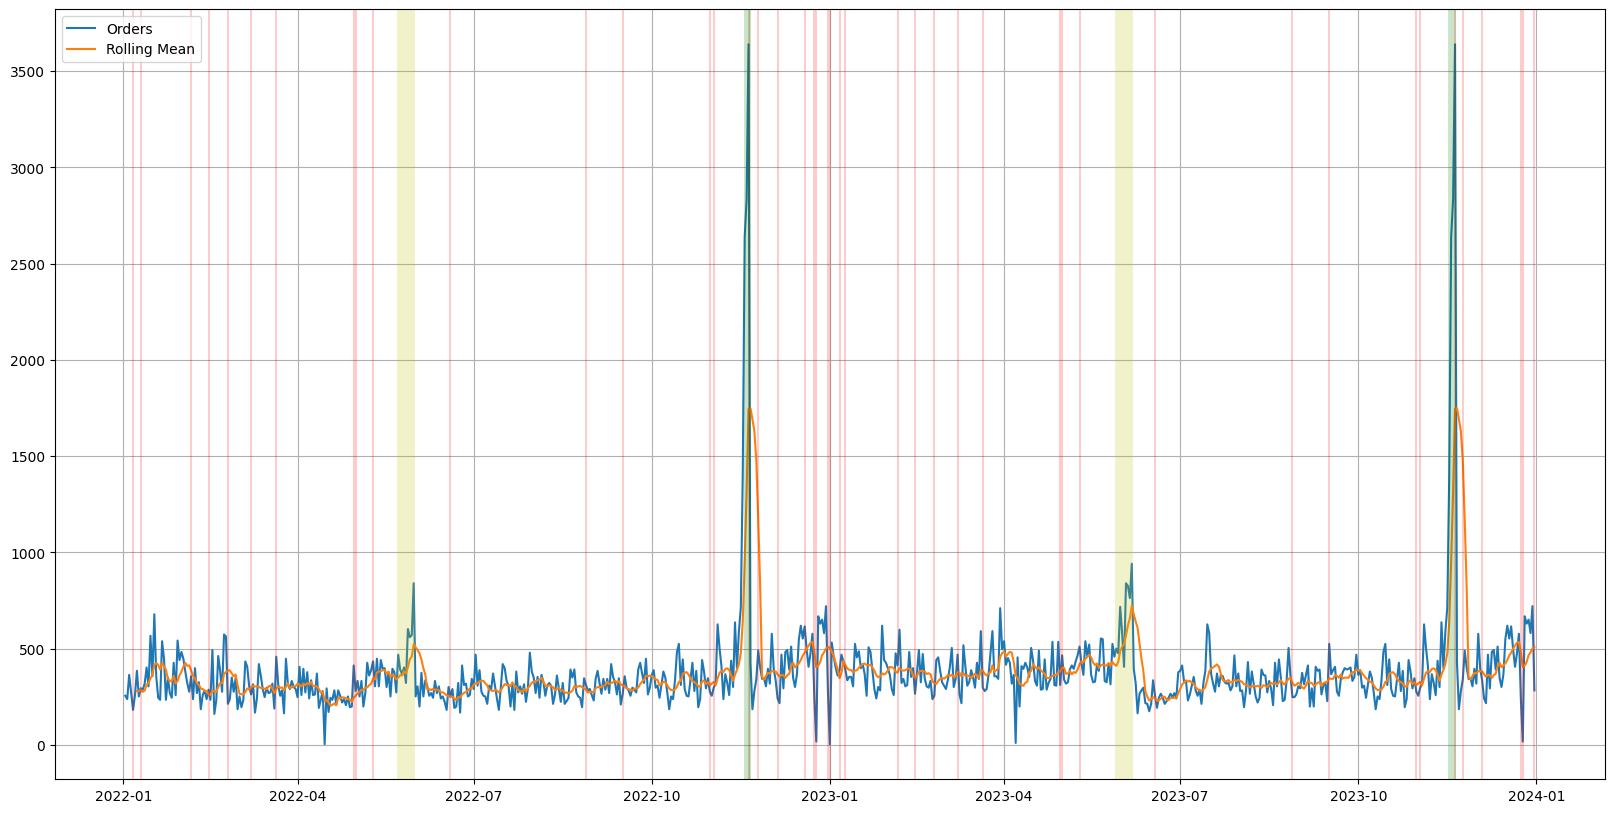

In [83]:

summary = new_df.groupby("Date")["Amount"].sum()
summary_holidays = new_df.groupby("Date")["Is_holiday"].prod()
summary_bf = new_df.groupby("Date")["Buen_fin"].prod()
summary_hs = new_df.groupby("Date")["Hot_sale"].prod()
rolling = summary.rolling(window=7)

plt.figure(figsize=(20, 10))
plt.plot(summary, label="Orders")
plt.plot(rolling.mean(), label="Rolling Mean")
plt.grid(True)
for idx, value in summary_holidays.items():
    if value:
        plt.axvline(x=idx, color="r", alpha=0.2)
for idx, value in summary_bf.items():
    if value:
        plt.axvline(x=idx, color="g", alpha=0.2)
for idx, value in summary_hs.items():
    if value:
        plt.axvline(x=idx, color="y", alpha=0.2)
plt.legend()
plt.show()

**Result and export**

In [84]:
new_df

,Date,Location,Product,Amount,Total,Unit_price,Weekday,Is_holiday,Buen_fin,Hot_sale
0,2022-01-02,Monterrey,Producto 11,7.0,40461.470,5780.21,Sunday,0,0,0
1,2022-01-02,San Luis,Producto 11,3.5,18162.130,5189.18,Sunday,0,0,0
2,2022-01-02,Queretaro,Producto 6,3.5,23477.440,6707.84,Sunday,0,0,0
3,2022-01-02,Monterrey,Producto 24,3.5,31083.500,8881.00,Sunday,0,0,0
4,2022-01-02,Monterrey,Producto 15,7.0,42846.020,6120.86,Sunday,0,0,0
...,...,...,...,...,...,...,...,...,...,...
47310,2022-12-31,Monterrey,Producto 273,3.5,26230.715,7494.49,Saturday,1,0,0
47311,2022-12-31,Cadereyta,Producto 273,3.5,35273.210,10078.06,Saturday,1,0,0
47312,2022-12-31,Monterrey,Producto 273,3.5,41274.205,11792.63,Saturday,1,0,0
47313,2022-12-31,Queretaro,Producto 273,3.5,15192.100,4340.60,Saturday,1,0,0


In [85]:
new_df.to_csv("../data/processed/encoded_db_cleaned.csv", index=False)

# Pivot Table

In [86]:
pt = new_df
pt["Unit_price"] = pt["Unit_price"] * pt["Amount"]
pt = pt.groupby(['Date']).agg({'Amount':'sum', 'Unit_price':'sum', 'Weekday':'min', 'Is_holiday':'prod','Hot_sale':'prod','Buen_fin':'prod'}).reset_index().sort_values('Date')
pt["Unit_price"] = pt["Unit_price"] / pt["Amount"]
pt

,Date,Amount,Unit_price,Weekday,Is_holiday,Hot_sale,Buen_fin
0,2022-01-02,255.5,7384.625616,Sunday,0,0,0
1,2022-01-03,238.0,6150.141765,Monday,0,0,0
2,2022-01-04,364.0,6220.821538,Tuesday,0,0,0
3,2022-01-05,273.0,6824.337692,Wednesday,0,0,0
4,2022-01-06,182.0,8041.052308,Thursday,1,0,0
...,...,...,...,...,...,...,...
724,2023-12-27,630.0,6271.283056,Wednesday,0,0,0
725,2023-12-28,651.0,6455.933710,Thursday,0,0,0
726,2023-12-29,581.0,7220.616084,Friday,0,0,0
727,2023-12-30,721.0,6803.676602,Saturday,0,0,0


In [87]:
pt.to_csv("../data/processed/date_pivot_table.csv", index=False)